In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from langdetect import detect

import warnings; warnings.simplefilter('ignore')

# Categorizing Videos By Text

In [2]:
# Video Related Features
dfData = pd.read_csv('../data/All_data_cbs.csv')

#nsfw

dfNSFW = pd.read_csv('../data/all_virality_nsfw.csv')

In [3]:
dfNSFW.rename(columns={'video_id' : 'Id'}, inplace = True)

In [4]:
dfData = dfData[dfData['channelVideoCount']<2000]
dfData = dfData[dfData['subscriberCount'] >0]


In [5]:
dfData = dfData.merge(dfNSFW,on='Id',how='left')

In [6]:
dfData['nsfw_score'] = dfData['nsfw_score'].fillna(0)


In [7]:
dfData.head()

,Unnamed: 0,Unnamed: 0.1,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,...,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,PublishedYear,ChannelAge,Title-clickbait,PrevTitle-clickbait,nsfw_score
0,0,0,0,Scp3JH3eVLw,Depeche Mode It's No Good,DANCA MUITO.,0,0,18,0,...,2.0,14.0,2012-03-28T18:01:31.000Z,3911.0,the best of Jay cutler Dorian Yates,2017,2008,0.660503,0.782542,0.004721
1,1,1,1,wLqmkz6u8G4,the best of Jay cutler Dorian Yates,Jay cutler e Dorian Yates,14,2,3911,0,...,2.0,8.0,2010-08-23T16:12:50.000Z,3853.0,Iron Man Andy photos NO PAIN NO GAIN,2012,2008,0.782542,0.974470,0.357800
2,2,2,2,nKMsh79uOcM,Iron Man Andy photos NO PAIN NO GAIN,Iron Man Andy muscle NO PAIN NO GAIN,8,2,3853,0,...,2.0,3.0,2010-05-17T10:15:48.000Z,1392.0,the mission SEVERINA,2010,2008,0.974470,0.116492,0.507079
3,3,3,4,E--7XtuuqAg,Mooring Anchor Carry 120kg at Papar Strongestm...,Only manage 11 meters,0,0,56,0,...,0.0,0.0,2016-10-10T15:01:02.000Z,74.0,Tire Flip 450kg at Papar Strongestman 2016,2016,2011,0.323020,0.260023,0.022668
4,4,4,5,fdsppIOelPw,Tire Flip 450kg at Papar Strongestman 2016,450kg x 5 flips,0,0,74,0,...,0.0,0.0,2016-10-10T14:59:15.000Z,46.0,Farmer Walk 125kg each hand at Papar Strongest...,2016,2011,0.260023,0.141004,0.001376


# Feature Creation using Title and Description Text

## Looking at Categorical Workouts

In [8]:
# Conver to lower case 
dfData['Title'] = dfData['Title'].str.lower()


# How To
dfData['HowTo'] = (dfData['Title'].str.contains('how'))

# Motivational
dfData['Motivation'] = (dfData['Title'].str.contains('motivation'))


# Transformation
dfData['Transform'] = (dfData['Title'].str.contains('transform'))

# Abs Workout
dfData['Abs Video'] = (dfData['Title'].str.contains('abs')  | 
                       dfData['Title'].str.contains('six') | 
                       dfData['Title'].str.contains(' 6') | 
                       dfData['Title'].str.contains('abdomen'))
        
# Chest Workout
dfData['Chest Video'] = (dfData['Title'].str.contains('chest')  |
                         dfData['Title'].str.contains('pushup') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('push up') |
                         dfData['Title'].str.contains('dumbell press'))

# Back Workouts 
dfData['Back Video'] = (dfData['Title'].str.contains('back') | 
                        dfData['Title'].str.contains('pull up') | 
                        dfData['Title'].str.contains('chin up')  | 
                        dfData['Title'].str.contains('deadlift'))

# Leg Workouts
dfData['Legs Video'] = (dfData['Title'].str.contains('leg') | 
                        dfData['Title'].str.contains('squat') | 
                        dfData['Title'].str.contains('butt') | 
                        dfData['Title'].str.contains('quad') | 
                        dfData['Title'].str.contains('calve') )

# Arm Workout
dfData['Arm Video'] = (dfData['Title'].str.contains('shoulder') | 
                       dfData['Title'].str.contains('arm') | 
                       dfData['Title'].str.contains('bicep')  |
                       dfData['Title'].str.contains('tricep') | 
                       dfData['Title'].str.contains('delt'))



In [9]:
dfData.loc[dfData['Abs Video'] == True , 'Category'] = 'Abs'
dfData.loc[dfData['Chest Video'] == True , 'Category'] = 'Chest'
dfData.loc[dfData['Back Video'] == True, 'Category'] = 'Back'
dfData.loc[dfData['Legs Video'] == True, 'Category'] = 'Legs'
dfData.loc[dfData['Arm Video'] == True, 'Category'] = 'Arms'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['HowTo'] == True, 'Category'] = 'HowTo'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['Transform'] == True, 'Category'] = 'Transform'

In [10]:
#dfData = dfData.drop(['Abs Video', 'Chest Video','Back Video','Legs Video', 'Arm Video'], axis =1 )
dfData[dfData['Category'].isnull()].shape[0]

67831

In [11]:
dfData = dfData[dfData['Category'].notnull()]

In [12]:
absVid = dfData[dfData['Category'] == 'Abs']
chestVid = dfData[dfData['Category'] == 'Chest']
backVid = dfData[dfData['Category'] == 'Back']
legsVid = dfData[dfData['Category'] == 'Legs']
armsVid = dfData[dfData['Category'] == 'Arms']

print "Number of Abs Related Videos: " + str(absVid.shape[0])
print "Number of Chest Related Videos: " + str(chestVid.shape[0])
print "Number of Back Related Videos: " + str(backVid.shape[0])
print "Number of Leg Related Videos: " + str(legsVid.shape[0])
print "Number of Arm Related Videos: " + str(armsVid.shape[0])

Number of Abs Related Videos: 1871
Number of Chest Related Videos: 2675
Number of Back Related Videos: 3284
Number of Leg Related Videos: 4356
Number of Arm Related Videos: 4496


## Maybe just Body Part Videos

In [13]:
#dfData = dfData[dfData['Category'].notnull()]
#dfData.shape[0]

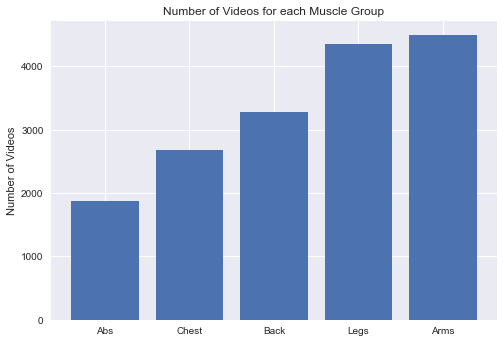

In [14]:
yCols = ['Abs', 'Chest', 'Back', 'Legs', 'Arms']
xCols = [absVid.shape[0], chestVid.shape[0], backVid.shape[0], legsVid.shape[0], armsVid.shape[0]]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Number of Videos")
plt.title("Number of Videos for each Muscle Group")

## Observation
Legs/Abs/Arms being the most since they target both a guy/girl audience

## Understanding View Distribution

Category
Motivation    129344.721637
Transform      40973.867890
Chest          28579.705421
HowTo          24131.251253
Abs            20405.567076
Arms           19198.255116
Legs           16286.413453
Back           16042.858100
Name: ViewCount, dtype: float64


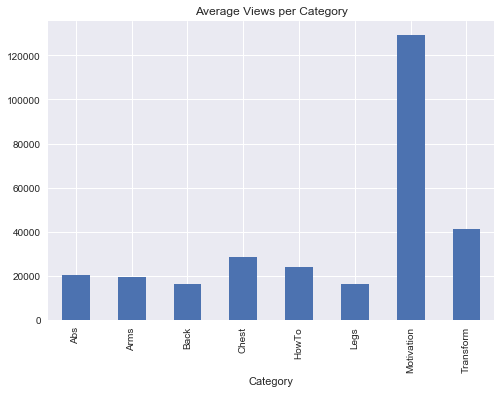

In [15]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').ViewCount.mean().sort_values(ascending = False))
plt.title("Average Views per Category")
plt.show()

Category
Motivation    707.408555
Transform     396.515596
HowTo         381.314844
Abs           273.920898
Chest         262.340935
Back          237.606882
Legs          213.938017
Arms          188.471530
Name: LikeCount, dtype: float64


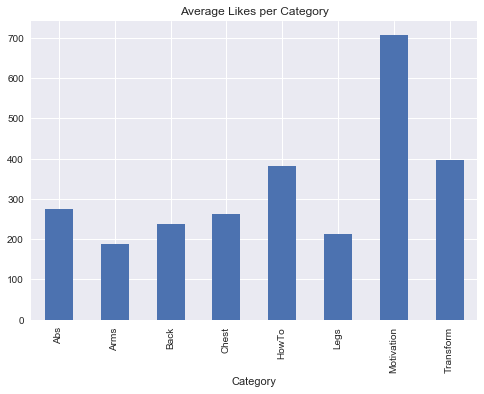

In [16]:
dfData.groupby('Category').LikeCount.mean().plot(kind="bar")
print(dfData.groupby('Category').LikeCount.mean().sort_values(ascending = False))
plt.title("Average Likes per Category")
plt.show()

Category
HowTo         66.276482
Transform     54.906422
Motivation    51.208308
Chest         36.995140
Back          30.626979
Legs          27.453168
Abs           24.502405
Arms          24.423932
Name: CommentCount, dtype: float64


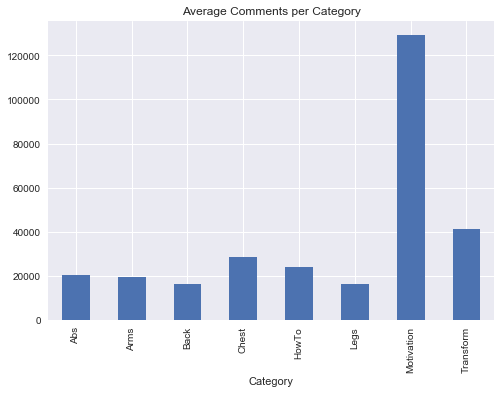

In [17]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').CommentCount.mean().sort_values(ascending = False))
plt.title("Average Comments per Category")
plt.show()

## Observation

Despite Legs having more videos than chest/abs, it has the least amount of views and likes.
The most liked videos are chest and abs

### Categorizing by "Sponsored" and "Description Box" 

In [18]:
# Abs Workout
dfData['isSponsored'] = (dfData['Description'].str.contains('sponsored')  | 
                       dfData['Description'].str.contains('provided by'))

dfData['hasDiscount'] = (dfData['Description'].str.contains("discount") |
                        dfData['Description'].str.contains("code"))

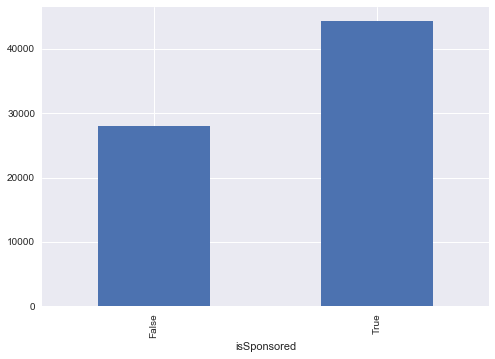

In [19]:
dfData.groupby('isSponsored').ViewCount.mean().plot(kind="bar")

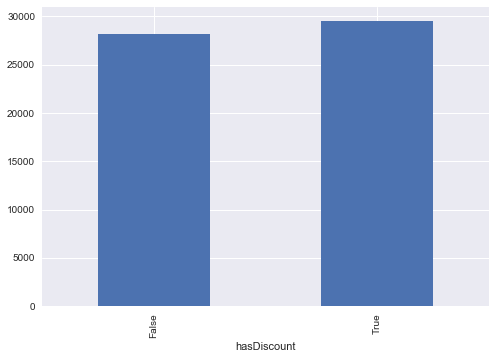

In [20]:
dfData.groupby('hasDiscount').ViewCount.mean().plot(kind="bar")

In [21]:
dfData['LikeDislikeRatio'] = dfData['LikeCount']/(dfData['LikeCount'] + dfData['DislikeCount'])

In [22]:
# Motivation
# Transformation
# Keywords: Ripped/Extreme/sexy/fat/intense
# BodyBuilding
# Tutorial/How To

In [23]:
dfData.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'rowHash', u'Id', u'Title',
       u'Description', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'FavoriteCount', u'CommentCount', u'PublishedAt', u'Channel Id',
       u'Channel Title', u'Lang', u'publishedAt', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'nextHash',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevPublishedAt', u'PrevViewCount', u'PrevTitle', u'PublishedYear',
       u'ChannelAge', u'Title-clickbait', u'PrevTitle-clickbait',
       u'nsfw_score', u'HowTo', u'Motivation', u'Transform', u'Abs Video',
       u'Chest Video', u'Back Video', u'Legs Video', u'Arm Video', u'Category',
       u'isSponsored', u'hasDiscount', u'LikeDislikeRatio'],
      dtype='object')

In [24]:
dfData.shape

(24627, 43)

In [25]:
import datetime, dateutil.parser
    
def defineWeeks(s):
    channelAge = dateutil.parser.parse(s)
    dt = dateutil.parser.parse("Dec 3 2017 12:00PM")
    time_difference = dt - channelAge.replace(tzinfo=None)
    time_difference_in_weeks = time_difference.days/7
    return time_difference_in_weeks

def feature_engineer(dfData):
    dfData =dfData.drop(['Category'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    dfData['is_Abs'] = dfData['Abs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Chest'] = dfData['Chest Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Back'] = dfData['Back Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Legs'] = dfData['Legs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Arms'] = dfData['Arm Video'].apply(lambda x: 1 if x==True else 0)
    dfData['isSponsored'] = dfData['isSponsored'].apply(lambda x: 1 if x==True else 0)
    dfData['Motivation'] = dfData['Motivation'].apply(lambda x: 1 if x==True else 0)
    dfData['HowTo'] = dfData['HowTo'].apply(lambda x: 1 if x==True else 0)
    dfData['WeeksPublished'] = dfData['PublishedAt'].apply(defineWeeks)
    dfData['ChannelAge'] =  dfData['publishedAt'].apply(defineWeeks)
    dfData['channelViewCount'] = np.log1p(dfData['channelViewCount'])
    dfData = dfData.drop(['Title','Description','PublishedAt','publishedAt','Channel Id','Channel Title','Abs Video','Chest Video','Back Video',
                          'Legs Video','Arm Video','PublishedAt','PublishedYear','PrevTitle-clickbait','PrevPublishedAt','Id','Unnamed: 0','Unnamed: 0.1','rowHash','FavoriteCount','nextHash','hasDiscount','PrevTitle'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

def drop_engineered_features(dfData):
    dfData = dfData.drop(['nsfw_score','Title-Clickbait'],axis = 1)
    return dfData

def drop_categoricals(dfData):
    dfData = dfData.drop(['is_Abs','is_Chest','is_Back','is_Legs','is_Arms','isSponsored','is_english','HowTo','Motivation','Transform'],axis =1)
    return dfData

In [26]:
df = feature_engineer(dfData).drop('LikeDislikeRatio',axis =1)

In [27]:
df.columns

Index([u'LikeCount', u'DislikeCount', u'ViewCount', u'CommentCount',
       u'subscriberCount', u'channelVideoCount', u'channelViewCount',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevViewCount', u'ChannelAge', u'Title-clickbait', u'nsfw_score',
       u'HowTo', u'Motivation', u'Transform', u'isSponsored', u'is_english',
       u'is_Abs', u'is_Chest', u'is_Back', u'is_Legs', u'is_Arms',
       u'WeeksPublished'],
      dtype='object')

In [28]:
X, y = df.drop('ViewCount',axis = 1) , np.log1p(df['ViewCount'])

In [29]:
def checkForNull(X,y):
    X = X.as_matrix().astype(float)
    print "Check For Null Values"
    for i in range(0,len(df.columns)-1):
        print df.columns[i]
        print np.any(np.isnan(X[:,i]))
    print "Check for Pred:"
    y = y.as_matrix().astype(float)
    print np.any(np.isnan(y))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor


In [31]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



In [32]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.90362173519636357

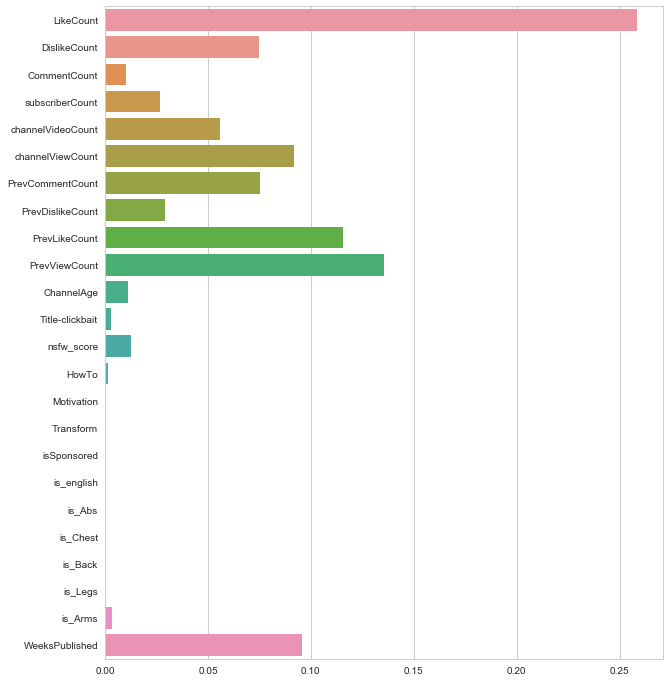

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [34]:
df = drop_categoricals(drop_obvious_features(feature_engineer(dfData))).drop('LikeDislikeRatio',axis = 1)
print df.columns
X, y = df.drop(['ViewCount'],axis=1), np.log1p(df['ViewCount'])
# checkForNull(X,y)
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)



Index([u'ViewCount', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
       u'PrevLikeCount', u'PrevViewCount', u'ChannelAge', u'Title-clickbait',
       u'nsfw_score', u'WeeksPublished'],
      dtype='object')


0.69852565124451527

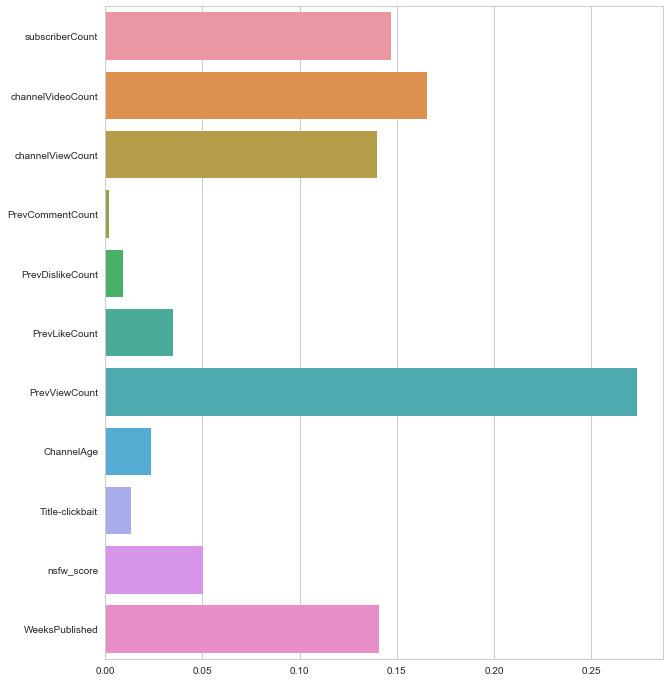

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=train_X.columns)

In [36]:
reg = XGBRegressor(n_estimators = 1000)

reg.fit(train_X, train_y)
print reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("xgb001.pickle.dat", "wb"))

0.708269293353


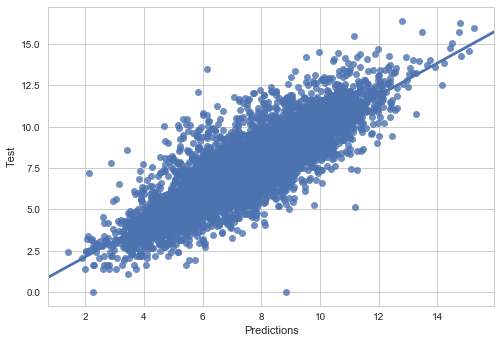

In [37]:
y_pred = reg.predict(test_X)
plot_df = pd.DataFrame(y_pred, columns=['Predictions'])
plot_df['Test'] = np.array(test_y)
sns.regplot(x='Predictions', y='Test', data=plot_df)

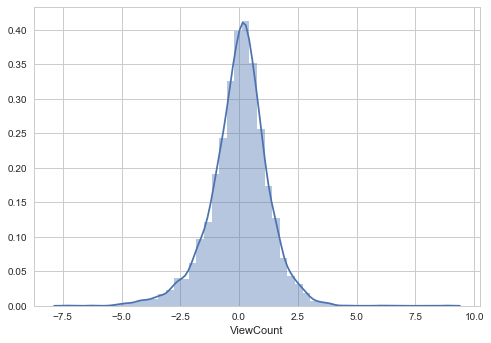

In [38]:
residuals = y_pred - test_y

sns.distplot(residuals)

# Load in Pickle To Test

In [124]:

# load model from file
loaded_model = pickle.load(open("xgb001.pickle.dat", "rb"))


[  1.49500000e+03   3.70000000e+01   1.41689291e+01   0.00000000e+00
   0.00000000e+00   3.00000000e+00   7.57000000e+02   3.84000000e+02
   1.80786461e-01   6.64659140e-02   2.76000000e+02]


In [134]:
y_pred = loaded_model.predict(pd.DataFrame(np.array(test_X)[0])

,subscriberCount,channelVideoCount,channelViewCount,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevViewCount,ChannelAge,Title-clickbait,nsfw_score,WeeksPublished
30880,1495,37,14.168929,0.0,0.0,3.0,757.0,384,0.180786,0.066466,276


In [143]:
X = pd.DataFrame(np.array(test_X)[0],index = test_X.columns).transpose()
loaded_model.predict(X)

array([ 8.06909561], dtype=float32)

In [132]:
test_X.columns

Index([u'subscriberCount', u'channelVideoCount', u'channelViewCount',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevViewCount', u'ChannelAge', u'Title-clickbait', u'nsfw_score',
       u'WeeksPublished'],
      dtype='object')

In [120]:
test_X.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index([u'subscriberCount', u'channelVideoCount', u'ChannelAge',
        u'WeeksPublished'],
       dtype='object'),
 dtype('float64'): Index([u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
        u'PrevLikeCount', u'PrevViewCount', u'Title-clickbait', u'nsfw_score'],
       dtype='object')}

# Analysis on ClickBait and Views

(0, 1)

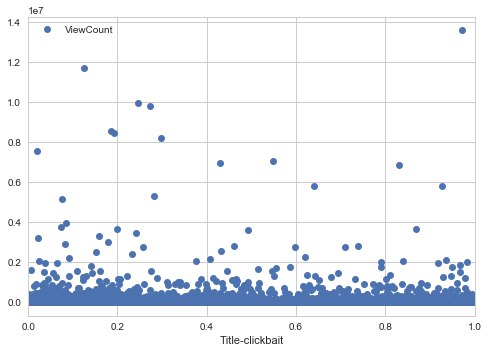

In [58]:
import matplotlib.pyplot as plt
dfData['LogView'] = np.log1p(dfData['ViewCount'])
dfData.plot(x='Title-clickbait', y='ViewCount', style='o')

plt.xlim(0, 1)

In [77]:
smallView = dfData[dfData['ViewCount']<0.5e7]
bigView = dfData[dfData['ViewCount']>=0.5e7]

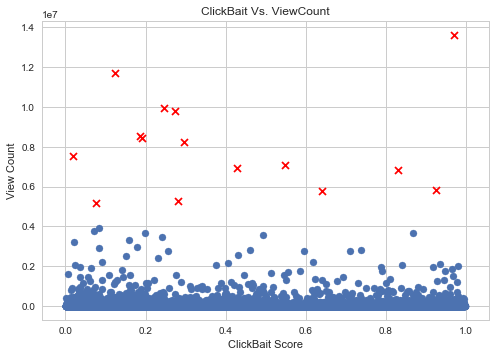

In [80]:
plt.scatter(smallView['Title-clickbait'],smallView['ViewCount'],marker= 'o')
plt.scatter(bigView['Title-clickbait'],bigView['ViewCount'],marker = 'x',color = 'r')
plt.title("ClickBait Vs. ViewCount")
plt.xlabel('ClickBait Score')
plt.ylabel('View Count')

In [40]:
dfData.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'rowHash', u'Id', u'Title',
       u'Description', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'FavoriteCount', u'CommentCount', u'PublishedAt', u'Channel Id',
       u'Channel Title', u'Lang', u'publishedAt', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'nextHash',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevPublishedAt', u'PrevViewCount', u'PrevTitle', u'PublishedYear',
       u'ChannelAge', u'Title-clickbait', u'PrevTitle-clickbait',
       u'nsfw_score', u'HowTo', u'Motivation', u'Transform', u'Abs Video',
       u'Chest Video', u'Back Video', u'Legs Video', u'Arm Video', u'Category',
       u'isSponsored', u'hasDiscount', u'LikeDislikeRatio'],
      dtype='object')

In [47]:
dfData['Title-clickbait'].max() - dfData['Title-clickbait'].min()

0.99848539885710297